<a href="https://colab.research.google.com/github/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/module04_03_CNN_training_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15 Convolutional Neural Networks in Pytorch

If you are planning to use `pytorch` on the workstations installed in the Department of Computer Science, you must execute this command

`export PYTHONPATH=$PYTHONPATH:/usr/local/anaconda/lib/python3.7/site-packages/`

A better solution is to add it to your startup script, such as `.bashrc`.

A more complete example of implementing a convolutional network in Pytorch is [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [1]:
# Modified from https://github.com/vinhkhuc/PyTorch-Mini-Tutorials

import numpy as np

import torch
from torch.autograd import Variable

import time

import gzip
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In our `numpy` version of a CNN, the constructor was called like
```python
    patch_size = 5
    nnet = NeuralNetworkClassifierCNN(28*28,
                                      [2, 2],
                                      len(np.unique(T)),
                                      patch_size=patch_size,
                                      stride=2)
```

Let's define our `pytorch` version with a contructor that is called like
```python
    nnet = ConvNet(28*28,
                   n_hiddens_per_conv_layer=[4, 2],
                   n_hiddens_per_fc_layer=[10],
                   len(np.unique(T)),
                   patch_size_per_conv_layer=[5, 4],
                   stride_per_conv_layer=[2, 2])                   
```

Compare these two definitions. What is different about them?

Let's first review the general principles of backpropagation from "vanilla" neural nets:
<img src="http://www.cs.colostate.edu/~cs445/notebooks/two-layer-nn-with-targets_full_backprop.png">

In plain English, there are $K$ output nodes.  In a plain non-linear regression neural network, that means that the network should output $K$ values for any input sample (e.g., input a bunch of a values about a car, and predict MPG, horsepower, and displacement).  In a neural network classifier, this would mean that there are $K$ classes and the network outputs probabilities that the input sample falls into each class.

Weight update follows the red lines in the figure above.  The value of a particular weight will be updated based on a value that is partially derived from the weights in later layers in the network. ("Partially derived" is here used in the colloquial sense with no pun intended---even though the partial derivative is crucial to this operation!)

Weight updates in $V$ depend to some extent on weight updates in $W$.

(Let us assume 2 units $W$ in the output layer and a single hidden unit $v$ for now.) If these are the derivatives we use:

$$
       \begin{align*}
       \frac{\partial E}{\partial w_1} & = -2 (t_1-y_1) z \\
       \frac{\partial E}{\partial v} & = -2 ( (t_1-y_1) w_1 + (t_2-y_2) w_2  ) (1-z^2) x
       \end{align*}
$$

... you can see that the update to $w_1$ $\propto$ the product of the error and $z$, the input to the layer.  The update to $v$, the hidden layer node, then depends on sum of the error times the weights in $W$, times the derivative of the activation function w.r.t. $z$ times the input to the hidden layer ($x$).

OK, I get how weight update works.  What was the point of that?

In [2]:
def draw_neg_image(image, label=''):
    plt.imshow(-image, cmap='gray', vmin=-1, vmax=0)
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

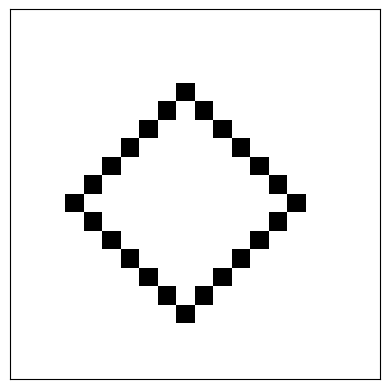

In [3]:
diamond = np.array([[0] * 20,
                        [0] * 20,
                        [0] * 20,
                        [0] * 20,
                        [0] * 9 + [1] + [0] * 10,
                        [0] * 8 + [1, 0, 1] + [0] * 9,
                        [0] * 7 + [1, 0, 0, 0, 1] + [0] * 8,
                        [0] * 6 + [1, 0, 0, 0, 0, 0, 1] + [0] * 7,
                        [0] * 5 + [1, 0, 0, 0, 0, 0, 0, 0, 1] + [0] * 6,
                        [0] * 4 + [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] + [0] * 5,
                        [0] * 3 + [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] + [0] * 4,
                        [0] * 4 + [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] + [0] * 5,
                        [0] * 5 + [1, 0, 0, 0, 0, 0, 0, 0, 1] + [0] * 6,
                        [0] * 6 + [1, 0, 0, 0, 0, 0, 1] + [0] * 7,
                        [0] * 7 + [1, 0, 0, 0, 1] + [0] * 8,
                        [0] * 8 + [1, 0, 1] + [0] * 9,
                        [0] * 9 + [1] + [0] * 10,
                        [0] * 20,
                        [0] * 20,
                        [0] * 20])
draw_neg_image(diamond)

There are 64 patches


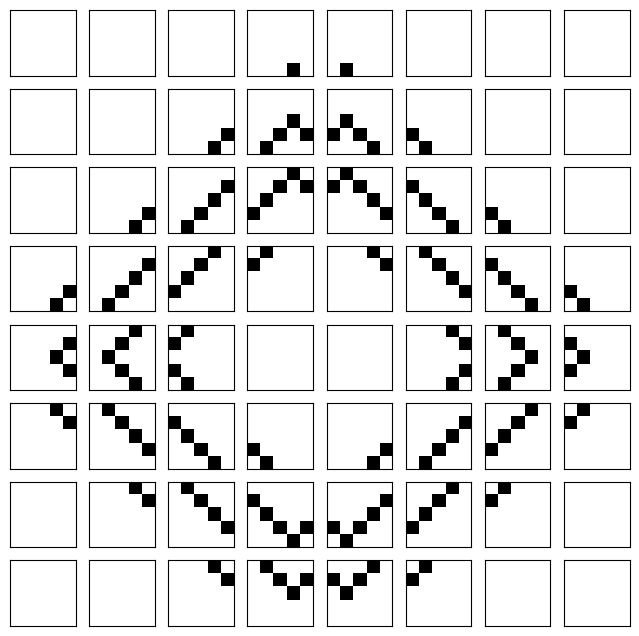

In [4]:
patch_size = 5
stride = 2

patches = []
for row in range(0, 20, stride):
    for col in range(0, 20, stride):
        if row + patch_size < 20 and col + patch_size < 20:
            patches.append(diamond[row:row + patch_size, col:col + patch_size])

n_plot_rows = int(np.sqrt(len(patches)))
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(n_plot_rows, n_plot_rows, ploti)
    draw_neg_image(patch, '')

print("There are %s patches" % len(patches))

A single convolutional unit, or "filter" will be applied to each of these patches (e.g., we're going to do `prod = C @ patch` where `C` is the weights of the convolutional unit).  Then the sum of all values in `prod` becomes the scalar value representing how reponsive the values in the patch are to the values in the filter.  This value is propagated through the network.

$$
      \begin{align*}
        {\bf Z} &= h(\tilde{\bf X} {\bf V}) \leftarrow {\bf V} \text{ are now our convolutional units}\\
        {\bf Y} &= \tilde{\bf Z} {\bf W}\\
        {\bf F} &= e^{\bf Y}\\
        {\bf S} &= \tilde{\bf F}_{K}\;\;\;\;\;\;\;\;\;\;\;\;\; \text{ sum across columns}\\
        {\bf G} &= {\bf Fv} / \left [ {\bf S}, {\bf S},\ldots,{\bf S} \right ] \;\;\; {\bf S} \text{ are column vectors }\\
        LL &=  \sum {\bf Ti} \log {\bf G}\\
      \end{align*}
$$

Therefore to get these:

$$
      \begin{align*}
        \nabla_{\bf V} LL &=    \tilde{\bf X}^T \left ( ({\bf Ti} - {\bf G}) \hat{\bf W}^T \cdot  (1-{\bf Z}^2) \right )\\
        \nabla_{\bf W} LL &=   \tilde{\bf Z}^T ({\bf Ti} - {\bf G})
      \end{align*}
$$

You have to sum all $\frac{\partial E}{\partial\cdot}$ for each delta value in $\nabla_{\bf \cdot}$.  So for each convolutional unit `C` you have to find the delta for each scalar value `sum(prod)` that comes out of `C @ patch`, for every patch.

Let's review the backpropagation of weights in a CNN. We will assume this network has only a single convolutional layer, which is the first layer:
```python
        for layeri in range(n_layers - 1, -1, -1):
            if layeri == 0:
                # Convolutional layer
                # delta, backpropagated from a fully-connected layer, has multiple values for each
                # convolutional unit, for each application of it to each patch.  We must sum the dE_dWs
                # for all of those delta values by multiplying each delta value for each convolutional
                # unit by the patch values used to produce the output by the input values for the
                # corresponding patch.
                # Do this by first reshaping the backed-up delta matrix to the right form.
                patch_n_values = X_patches.shape[-1]
                n_conv_units = self.n_hiddens_per_layer[0]
                delta_reshaped = delta.reshape(-1, n_conv_units)
                # And we must reshape the convolutional layer input matrix to a compatible shape.
                conv_layer_inputs_reshaped = self.Ys[0].reshape(-1, patch_n_values)
                # Now we can calculate the dE_dWs for the convolutional layer with a simple matrix
                # multiplication.
                self.dE_dWs[layeri][1:, :] = conv_layer_inputs_reshaped.T @ delta_reshaped
                self.dE_dWs[layeri][0:1, :] = np.sum(delta_reshaped, axis=0)
            else:
                # Fully-connected layers
                # gradient of all but bias weights
                self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
                # gradient of just the bias weights
                self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
```

For a single convolutional layer, this sounds hairy enough!  But check the `pytorch` CNN definition again.

```python
    nnet = ConvNet(28*28,
                   n_hiddens_per_conv_layer=[4, 2],  # you can have multiple convolutional layers!
                   n_hiddens_per_fc_layer=[10],
                   len(np.unique(T)),
                   patch_size_per_conv_layer=[5, 4], # each with different patch sizes!!
                   stride_per_conv_layer=[2, 2])     # and different stride lengths!!!                
```

If only there were some tool we could use to automatically calculate gradients...

In [5]:
import numpy as np
import torch

class ConvNet(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers or
            len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append( torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride) )
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in  # n_hiddens_per_fc_layer[0]
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append( torch.nn.Linear(n_in, nh) )
            n_in = nh
        self.fc_layers.append( torch.nn.Linear(n_in, n_outputs) )

        self.to(self.device)


    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append( self.activation_function(conv_layer(Ys[-1])) )

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append( self.activation_function(fc_layer(Ys[-1].reshape(n_samples, -1))) )
            else:
                Ys.append( self.activation_function(fc_layer(Ys[-1])) )

        Ys.append(self.fc_layers[-1](Ys[-1]))
        return Ys


    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]


    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float().to(self.device)
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        X.requires_grad_(True)

        self.classes = torch.unique(T)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (n_epochs // 10) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self


    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1,1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y


    def use(self, X):
        # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float().to(self.device)
        Y = self.forward(X)
        probs = self.softmax(Y)
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()]
        return classes.cpu().numpy(), probs.detach().cpu().numpy()

In [6]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): n
Running on cpu


In [7]:
!nvidia-smi

Tue Mar 25 05:12:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
!wget https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/refs/heads/master/data/mnist.pkl.gz

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1]
Xtest = test_set[0]
Ttest = test_set[1]

print("Xtrain before reshaping %s: %s" % (Xtrain.shape,Xtrain))
print("Xtest before reshaping %s: %s" % (Xtest.shape,Xtest))

# Convolutional nets in pytorch require reshaping the input matrices
Xtrain_cnn = Xtrain.reshape(-1, 1, 28, 28)
Xtest_cnn = Xtest.reshape(-1, 1, 28, 28)

print("Xtrain after reshaping %s: %s" % (Xtrain_cnn.shape,Xtrain_cnn))
print("Xtest after reshaping %s: %s" % (Xtest_cnn.shape,Xtest_cnn))

--2025-03-25 05:12:56--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/refs/heads/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M  --.-KB/s    in 0.1s    

2025-03-25 05:12:57 (158 MB/s) - ‘mnist.pkl.gz’ saved [17051982/17051982]

Xtrain before reshaping (50000, 784): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Xtest before reshaping (10000, 784): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 

In [9]:
cnnet = ConvNet(28 * 28,
                [10, 20], # n_hiddens_per_conv_layer
                [5], # n_hiddens_per_fc_layer
                10,
                patch_size_per_conv_layer=[5, 7], stride_per_conv_layer=[2, 2], device=device)
cnnet.to(device)


n_epochs = 10
batch_size = 1000
learning_rate = 0.001
cnnet.train(Xtrain_cnn, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 1 Loss 1.991
adam: Epoch 2 Loss 1.630
adam: Epoch 3 Loss 1.405
adam: Epoch 4 Loss 1.221
adam: Epoch 5 Loss 1.070
adam: Epoch 6 Loss 0.942
adam: Epoch 7 Loss 0.834
adam: Epoch 8 Loss 0.742
adam: Epoch 9 Loss 0.665
adam: Epoch 10 Loss 0.600


ConvNet(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(10, 20, kernel_size=(7, 7), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=180, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=10, bias=True)
  )
)

In [10]:
Classes_pytorch, _ = cnnet.use(Xtest_cnn)
perc_pytorch = 100 * np.mean(Classes_pytorch == Ttest)
perc_pytorch

np.float64(93.36)

Let's now examine the effects of one layer's weights on an input.  First let's get the hyperparameters of the first layer.

In [11]:
list(cnnet.children())[0][0]

Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))

What do these 4 values mean?

Now let's view the outputs of each convolutional layer.

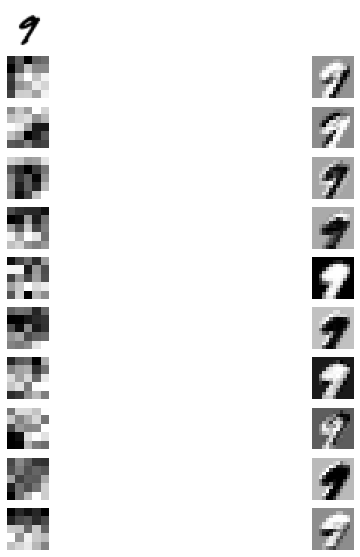

In [ ]:
x = Xtest_cnn[20:21] # grab a sample
x = torch.from_numpy(x).float().to(device)
Ys = cnnet.forward_all_outputs(x)
layer1weights = list(cnnet.children())[0][0].weight.data

plt.figure(figsize=(10, 10))
plt.subplot(11, 2, 1)
plt.imshow(-x.squeeze().cpu(), cmap='gray')
plt.axis('off')

ploti = 2
for i in range(10):
    ploti += 1
    plt.subplot(11, 2, ploti)
    plt.imshow(layer1weights[i].squeeze().cpu(), cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(11, 2, ploti)
    plt.imshow(Ys[1][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')

What do you observe here?

In [ ]:
list(cnnet.children())[0][1]

Conv2d(10, 20, kernel_size=(7, 7), stride=(2, 2))

These are the outputs of Layer 2


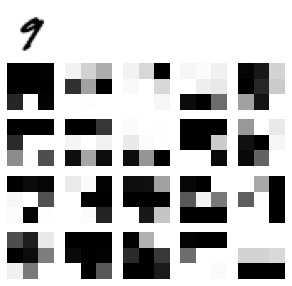

In [ ]:
layer2weights = list(cnnet.children())[1][0].weight.data

print("These are the outputs of Layer 2")

plt.figure(figsize=(5, 5))
plt.subplot(5, 5, 1)
plt.imshow(-x.squeeze().cpu(), cmap='gray')
plt.axis('off')

ploti = 5
for i in range(20):
    ploti += 1
    plt.subplot(5, 5, ploti)
    plt.imshow(Ys[2][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')

What do these outputs look like numerically?

In [ ]:
Ys[1][0, 9, :, :], Ys[1][0, 9, :, :].shape

(tensor([[ 0.1804,  0.1804,  0.1804,  0.1804,  0.1804,  0.1804,  0.1804,  0.1804,
           0.1804,  0.1804,  0.1804,  0.1804],
         [ 0.1804,  0.1804,  0.1804,  0.1804,  0.1804,  0.1804,  0.2331,  0.5157,
           0.5291,  0.2187,  0.1804,  0.1804],
         [ 0.1804,  0.1804,  0.1804,  0.1804,  0.1909,  0.5652,  0.9439,  0.9898,
           0.9880,  0.9439,  0.6532,  0.1821],
         [ 0.1804,  0.1804,  0.1804,  0.2289,  0.7679,  0.9754,  0.9736,  0.9573,
           0.9841,  0.9865,  0.8662,  0.1885],
         [ 0.1804,  0.1804,  0.2053,  0.7387,  0.9561,  0.9172,  0.7101,  0.6433,
           0.8103,  0.4371, -0.0027,  0.1747],
         [ 0.1804,  0.1804,  0.3874,  0.8579,  0.9598,  0.9256,  0.7033,  0.8321,
           0.5749,  0.0895, -0.2721,  0.1804],
         [ 0.1804,  0.1804, -0.0671, -0.4190, -0.5002, -0.6854, -0.3263,  0.0784,
           0.1722, -0.3222,  0.1431,  0.1804],
         [ 0.1804,  0.1804, -0.0733, -0.5834, -0.8159, -0.3921,  0.7294,  0.7263,
          -0.03

In [ ]:
Ys[2][0, 19, :, :], Ys[2][0, 19, :, :].shape

(tensor([[ 0.9999,  1.0000,  1.0000],
         [ 0.6460,  0.6492,  0.6978],
         [-0.9997, -1.0000, -1.0000]], device='cuda:0', grad_fn=<SliceBackward>),
 torch.Size([3, 3]))

OK, so each $7 \times 7$ filter applied to a $12 \times 12$ input to the second convolutional layer results in a $3 \times 3$ output.  Does that make sense?

In [ ]:
px = list(range(0,12)) # indices of the 12 x 12 image

i = 0
while i < px[-1]:
    print(px[i:i+7],len(px[i:i+7])) # how many intervals of size 7 can fit in an interval of 12 with stride 2?
    if len(px[i+2:i+2+7]) < 7: # patch size of 7
        break
    i += 2

print(i+7-(px[-1]-1), "pixels cropped")

[0, 1, 2, 3, 4, 5, 6] 7
[2, 3, 4, 5, 6, 7, 8] 7
[4, 5, 6, 7, 8, 9, 10] 7
1 pixels cropped


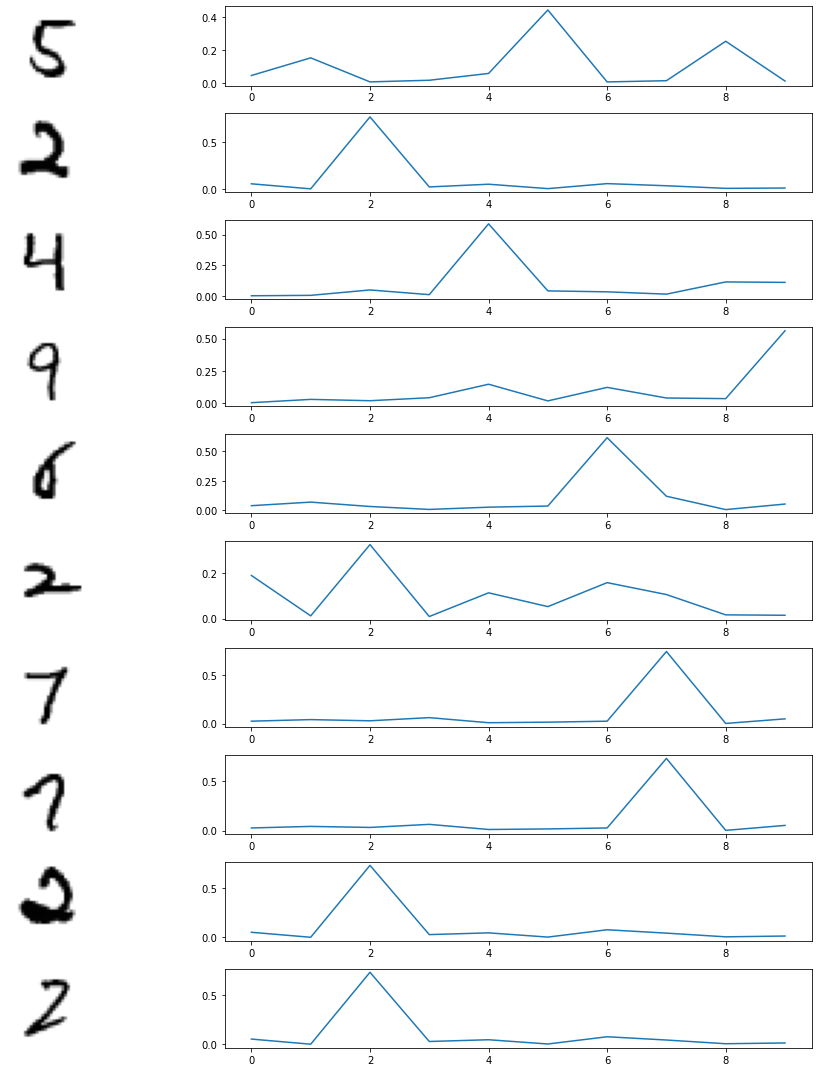

In [ ]:
first = np.random.randint(5000)

# grab 10 samples from a random place in the test set
x = Xtest_cnn[first:first + 10]
Classes, Probs = cnnet.use(x)

plt.figure(figsize=(15, 15))
ploti = 0
for i in range(10):
    ploti += 1
    plt.subplot(10, 2, ploti)
    plt.imshow(-x[i, 0, :, :], cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(10, 2, ploti)
    # Try calculating this my self
    Yprobs = Probs[i, :]
    plt.plot(Yprobs)
plt.tight_layout()